Histogram for per day Cumulative Visits

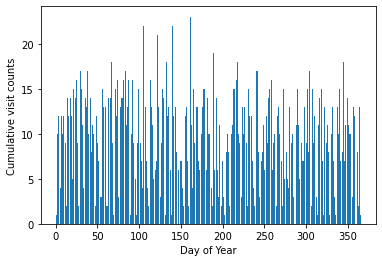

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from statistics import mean
import pickle
import seaborn as sns

%run constants.py
df = pd.read_csv(REARRANGED_DATA_FILEPATH)
doy_freq = []
for column in df:
    doy_freq .append(df[column].count())
doy_freq
del doy_freq[0]

from matplotlib import rcParams

rcParams['figure.figsize'] = 30,8


plt.style.context('fivethirtyeight')
plt.rcParams["figure.figsize"] = (60,20)
plt.bar(range(1, len(doy_freq) + 1), doy_freq)
plt.xlabel("Day of Year")
plt.ylabel("Cumulative visit counts")
plt.show()

In [2]:

with open(X_TRAIN_INPUT_SAVE_FILE, "rb") as f:
        x_train = pickle.load(f)
with open(Y_TRAIN_INPUT_SAVE_FILE, "rb") as f:
        y_train = pickle.load(f)
with open(X_TEST_INPUT_SAVE_FILE, "rb") as f:
        x_test = pickle.load(f)
with open(Y_TEST_INPUT_SAVE_FILE, "rb") as f:
        y_test = pickle.load(f)
with open(X_VAL_INPUT_SAVE_FILE, "rb") as f:
        x_val = pickle.load(f)
with open(Y_VAL_INPUT_SAVE_FILE, "rb") as f:
        y_val = pickle.load(f)
with open(EMBEDDING_MATRIX_SAVE_FILE, "rb") as f:
        embedding_matrix = pickle.load(f)

print("------Saving varaibles for reuse ------")
print(f"X_train shape: {x_train.shape}")
print(f"Y_train shape: {y_train.shape}")
print(f"X_test shape: {x_test.shape}")
print(f"Y_test shape: {y_test.shape}")
print(f"X_val shape: {x_val.shape}")
print(f"Y_val shape: {y_val.shape}")
print(f"Embedding shape: {embedding_matrix.shape}")
print(f"Total 0 values: {(y_train == 0).sum()}")
print(f"Total 1 values: {(y_train == 1).sum()}")

------Saving varaibles for reuse ------
X_train shape: (2465, 30, 200)
Y_train shape: (2465,)
X_test shape: (685, 30, 200)
Y_test shape: (685,)
X_val shape: (274, 30, 200)
Y_val shape: (274,)
Embedding shape: (10000, 100)
Total 0 values: 1346
Total 1 values: 1119


In [3]:
def shanon_diversity_index(y_train):

    from numpy import log
    
    cls_1_count = (y_train == 0).sum()
    cls_2_count = (y_train == 1).sum()
    N = cls_1_count + cls_2_count
    prob_cls_1 = cls_1_count/N
    prob_cls_2 = cls_2_count/N
    log_pi_cls_1 = log(prob_cls_1) * prob_cls_1
    log_pi_cls_2 = log(prob_cls_2) * prob_cls_2

    value = log_pi_cls_1 + log_pi_cls_2 
    
    H = value*-1
    shanon = H / log(2) 
    return shanon

In [4]:
print(f"Shanon Entropy measure of balance before balancing {shanon_diversity_index(y_train)}")

# Demonstrating better data balance following SMOTE
from imblearn.over_sampling import SMOTE
arr = x_train.reshape(len(x_train), -1)
sm = SMOTE(random_state=SEED)
x_train_bal, y_train_bal = sm.fit_resample(arr, y_train.ravel())
print(f"Shanon Entropy measure of balance after SMOTE balancing {shanon_diversity_index(y_train_bal)}")

Shanon Entropy measure of balance before balancing 0.9938739872011475
Shanon Entropy measure of balance after SMOTE balancing 1.0


In [5]:
# Get all classes where revisit

#Average word length per class
import numpy as np
norevisits = x_train[(y_train == 0)]
revisits = x_train[(y_train == 1)]
train_postprocessed_average_word_length = np.count_nonzero(x_train[:,29:,])/x_train.shape[0]
norevisits_train_postprocessed_average_word_length = np.count_nonzero(revisits[:,29:,])/revisits.shape[0]
revisits_train_postprocessed_average_word_length = np.count_nonzero(norevisits[:,29:,])/norevisits.shape[0]

print(f"Total Visits in train dataset {x_train.shape[0]}")
print(f"Average EHR length in postprocessed train dataset: {train_postprocessed_average_word_length}")
print(f"Average EHR length in postprocessed train norevisit class dataset: {norevisits_train_postprocessed_average_word_length }")
print(f"Average EHR length in postprocessed train revisit class dataset: {revisits_train_postprocessed_average_word_length}")


Total Visits in train dataset 2465
Average EHR length in postprocessed train dataset: 103.98215010141988
Average EHR length in postprocessed train norevisit class dataset: 114.18677390527256
Average EHR length in postprocessed train revisit class dataset: 95.49851411589896


In [6]:
with open(VOCAB_SAVE_FILE, "rb") as f:
        vocab = pickle.load(f)
all_train_visits = x_train[:,29,:,]
unique, counts = np.unique(all_train_visits, return_counts=True)
    
norevisits_unique, no_revisits_counts = np.unique(norevisits[:,29:], return_counts=True)
revisits_unique, revisits_counts = np.unique(revisits[:,29:], return_counts=True)

top_words = []
top_frequency = []

top_words_nrv = []
top_frequency_nrv = []

top_words_rv = []
top_frequency_rv = []

for index, value in enumerate(unique):
    top_words.append(vocab[value])


for index, value in enumerate(norevisits_unique):
    top_words_nrv.append(vocab[value])
    
for index, value in enumerate(revisits_unique):
    top_words_rv.append(vocab[value])

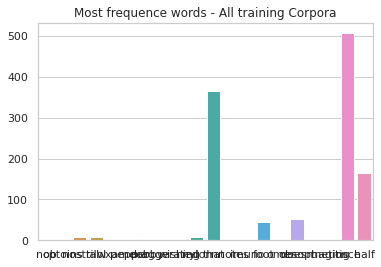

In [7]:
top_indexes = np.argsort(counts)[-22:]
top_indexes= top_indexes[2:22]

top_n_words = np.take(top_words[2:], top_indexes)
top_n_frequences = np.take(counts[2:], top_indexes)



sns.set_theme(style="whitegrid")
ax = sns.barplot(x=top_n_words , y=top_n_frequences).set(title='Most frequence words - All training Corpora', )
plt.show()

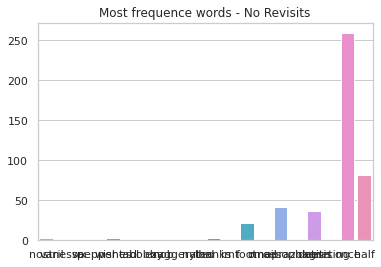

In [8]:
top_indexes_nrv = np.argsort(no_revisits_counts)[-22:]
top_indexes_nrv= top_indexes_nrv[2:22]

top_n_words_nrv = np.take(top_words_nrv[2:], top_indexes_nrv)
top_n_frequences_nrv = np.take(no_revisits_counts[2:], top_indexes_nrv)



sns.set_theme(style="whitegrid")
ax = sns.barplot(x=top_n_words_nrv , y=top_n_frequences_nrv).set(title='Most frequence words - No Revisits', )
plt.show()

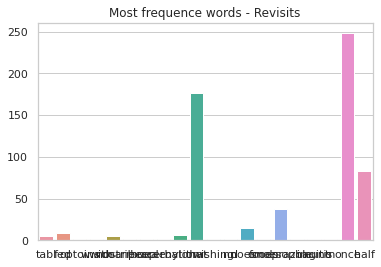

In [9]:
top_indexes_rv = np.argsort(revisits_counts)[-22:]
top_indexes_rv= top_indexes_rv[2:22]

top_n_words_rv = np.take(top_words_rv[2:], top_indexes_rv)
top_n_frequences_rv = np.take(revisits_counts[2:], top_indexes_rv)



sns.set_theme(style="whitegrid")
ax = sns.barplot(x=top_n_words_rv , y=top_n_frequences_rv).set(title='Most frequence words - Revisits', )
plt.show()

In [10]:
"Add readability index for all of the EHRS"

'Add readability index for all of the EHRS'